# Video Augmentation

참고 : 

- https://github.com/Rafalves883/Video-Augmentation
- https://www.tensorflow.org/tutorials/images/data_augmentation?hl=ko

# Step

1. video frames stored as images ndarrys
2. image preprocessing (mostly, image rotation)
3. images into video


(처음엔 image preprocessing 단계에서 참고 github에 정의된 메서드를 사용하려 했음. rotation 만 진행한다면 그렇게 할 필요없이 keras의 메서드 사용할 예정)

## 정리본

~~아래 코드들을 다 실행시켜 함수 정의 후 사용해야한다.~~
- step0 전까지 돌려서 사용할 수 있다. 아래는 과정 확인 코드
- 그리고 결국엔 step2-2 방식을 사용했다.

In [116]:
import random
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util
import cv2
from skimage import data
import warnings
from skimage import filters
from skimage import color
from skimage import exposure
from skimage.transform import rotate
from skimage.transform import warp
from skimage.transform import ProjectiveTransform
from skimage.transform import AffineTransform
import math
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
import tensorflow_addons as tfa

In [117]:
#turns video into frames
#frame rate 조절해서 프레임 수 바꾸기(30으로 설정한 이유는 fps값이 29.9이기 때문)
def get_frames(video_path, frameRate=1/29):
    vidcap = cv2.VideoCapture(video_path)
    def getFrame(sec):
        vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
        hasFrames,image = vidcap.read()
        return hasFrames, image
    images= []
    sec = 0
    count=1
    success = getFrame(sec)
    while success:
        count = count + 1
        sec = sec + frameRate
        sec = round(sec, 2)
        success, imagem = getFrame(sec)
        images.append(imagem)
    return images

In [118]:
#image rescale
rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255)
])
def first_prep_model(frames):
    rescale_frames = []
    for i in range(len(frames)):
        rescale_frames.append(rescale(frames[i]))
    return rescale_frames

In [119]:
def rotation(images, degree):
    img_arr = []
    for i in range(len(images)):
        rot_img = sk.transform.rotate(images[i],degree)
        img_arr.append(rot_img)
    return img_arr

In [120]:
def random_rotation1(images):
    def random_rotation(image_array, random_degree):
        # pick a random degree of rotation between 25% on the left and 25% on the right
        return sk.transform.rotate(image_array, random_degree)
    img_arroi=[]
    random_degree = random.uniform(-25, 25)
    for i in range(len(images)-1):
        image_with_random_noise = random_rotation(images[i],random_degree)
        img_arroi.append(image_with_random_noise)
    return img_arroi

In [121]:
#비디오 저장
def turn_video(name,clip,clip2=[],j=0,k=0): #clip2 확인하기
    h,w,l= clip[0].shape
    size=(w,h)    
    #코덱 확인 다시하기
    #param : 파일 저장될 이름, 코덱 (mp4 파일은 mp4v 사용), 초 당 프레임 수, 저장 사이즈
    out = cv2.VideoWriter(name,cv2.VideoWriter_fourcc(*'mp4v'), 29, size)# 동영상 재생 시간 2배 예상
    i=0
    for i in range(len(clip)-j):#if the python returns something with NoneType put j=1
        if k == 1: #k=1 to random noise, gaussian blur and random rotate
            out.write(np.uint8(clip[i]*clip2[i]))
        else:
            #print(clip[i].dtype) -> none type error 체크
            out.write(np.uint8(clip[i]))
    out.release()

In [122]:
# ex) output_video_path: "turn_video.mp4"
# ex) rot_rad: tf.constant(np.pi/8)
def vid_rot(origin_video_path, output_video_path, rot_rad):
    file = origin_video_path
    frames = get_frames(file)
    #first_prep = first_prep_model(frames)
    #second_prep = tfa.image.transform_ops.rotate(first_prep, rot_rad)
    second_prep = random_rotation1(frames)
    turn_vid = turn_video(output_video_path,second_prep)
    return turn_vid
    

In [123]:
rot_vid = vid_rot('origin/abnormal_gait1.mp4','outputs/rot_vid.mp4', tf.constant(np.pi/8))

하나의 영상에 대한 증강은 random_rotation이므로 vid_rot 함수를 반복 사용.

문제: 시간+번거로움이기에 keras 의 sequential 모델을 써보고 싶었는데 tensor 와 python 변환에 문제가 있었음.

## Step 0

- import
- file loading
- video info

In [58]:
import random
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util
import cv2
from skimage import data
import warnings
from skimage import filters
from skimage import color
from skimage import exposure
from skimage.transform import rotate
from skimage.transform import warp
from skimage.transform import ProjectiveTransform
from skimage.transform import AffineTransform
import math
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

In [59]:
file = 'origin/abnormal_gait1.mp4'

In [82]:
#video 정보
def video_info(filename):
    cap = cv2.VideoCapture(filename)
    
    if not cap.isOpened():
        print("could not open : ", filename)
        exit(0)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_play_time = cap.get(cv2.CAP_PROP_POS_MSEC)
    fourcc_of_video = int(cap.get(cv2.CAP_PROP_FOURCC))
    
    print('video length : ', length)
    print('video width : ', width)
    print('height : ',height)
    print('fps : ', fps)
    #print('프레임 재생 시간 : ', frame_play_time)
    print('코덱 코드 : ', fourcc_of_video)

In [83]:
video_info(file)

video length :  1034
video width :  600
height :  360
fps :  29.969566687599634
코덱 코드 :  828601953


## Step 1

- turns video into frames
- check the dtype, shape of video frame

In [78]:
#turns video into frames
#frame rate 조절해서 프레임 수 바꾸기(30으로 설정한 이유는 fps값이 29.9이기 때문)
def get_frames(video_path, frameRate=1/29):
    vidcap = cv2.VideoCapture(video_path)
    def getFrame(sec):
        vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
        hasFrames,image = vidcap.read()
        return hasFrames, image
    images= []
    sec = 0
    count=1
    success = getFrame(sec)
    while success:
        count = count + 1
        sec = sec + frameRate
        sec = round(sec, 2)
        success, imagem = getFrame(sec)
        images.append(imagem)
    return images

In [79]:
#frame 은 ndarray로 변환된 이미지 array
frame = get_frames(file)

In [69]:
frame[0].shape

(360, 600, 3)

In [70]:
frame[0].dtype

dtype('uint8')

In [86]:
len(frame)

1150

In [87]:
frame[-1].dtype

AttributeError: 'NoneType' object has no attribute 'dtype'

In [88]:
frame[-2].dtype

dtype('uint8')

## Step 2 - 1

### Preprocessing

- image resize
- image rescaling
- rotating

*image _resize는 input동영상의 너비, 높이의 비율을 그대로 가져와야할 것으로 예상되고 비율을 맞춰 크기를 맞추는 것으로 결정하면 좋을 것 같다.*

진행은 다수의 이미지들을 처리해야하므로 layer를 구성하여 처리한다.

계속 tensorflow import 가 되지 않아 나중에 gpu로 해보고 지금은 step2-2에서 시도해본다.

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

In [15]:
IMG_width = 180
IMG_height = 300
resize_and_rescale = tf.keras.Sequential([
  #layers.experimental.preprocessing.Resizing(IMG_width, IMG_height),
  layers.experimental.preprocessing.Rescaling(1./255)
])


2022-07-28 13:06:14.562375: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-28 13:06:14.578002: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-28 13:06:14.578912: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-28 13:06:14.582845: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

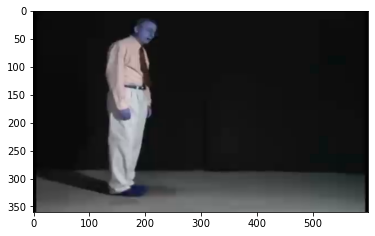

In [16]:
result = resize_and_rescale(frame[0])
_ = plt.imshow(result)

In [18]:
result = []
for i in range(len(frame)-1):
    result.append(resize_and_rescale(frame[i]))

In [21]:
result[0].shape

TensorShape([360, 600, 3])

In [22]:
len(result)

344

### layer 를 만들어서 data augmentation 진행

이미지 전처리 layer 를 만들어 한 번에 진행한다.

In [29]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [30]:
final = []
for i in range(len(result)):
    final.append(data_augmentation(result[i]))

random rotation으로 하면 한 프레임당 난리가 난다. 일정 각도로만 rotate 시키고 한 영상에 344frame이 나오니깐 이를 변환시킨다.

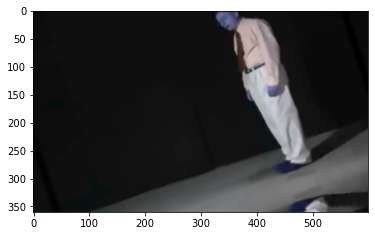

In [35]:
plt.imshow(final[0])

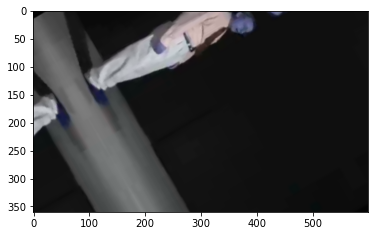

In [36]:
plt.imshow(final[1])

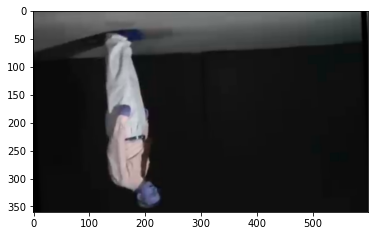

In [37]:
plt.imshow(final[2])

In [38]:
final

[<tf.Tensor: shape=(360, 600, 3), dtype=float32, numpy=
 array([[[0.01960784, 0.0509804 , 0.04705883],
         [0.02400848, 0.05035174, 0.04705883],
         [0.04705883, 0.04705883, 0.04705883],
         ...,
         [0.04313726, 0.04313726, 0.04313726],
         [0.04313726, 0.04313726, 0.04313726],
         [0.04313726, 0.04313726, 0.04313726]],
 
        [[0.01960784, 0.0509804 , 0.04705883],
         [0.01960784, 0.0509804 , 0.04705883],
         [0.04162233, 0.04783547, 0.04705883],
         ...,
         [0.04313726, 0.04313726, 0.04313726],
         [0.04313726, 0.04313726, 0.04313726],
         [0.04313726, 0.04313726, 0.04313726]],
 
        [[0.01960784, 0.0509804 , 0.04705883],
         [0.01960784, 0.0509804 , 0.04705883],
         [0.03313144, 0.04904845, 0.04705883],
         ...,
         [0.04313726, 0.04313726, 0.04313726],
         [0.04313726, 0.04313726, 0.04313726],
         [0.04313726, 0.04313726, 0.04313726]],
 
        ...,
 
        [[0.04105526, 0.06084077

In [39]:
len(final)

344

In [49]:
import tensorflow_addons as tfa

In [51]:
given_rad_rotation = tfa.image.transform_ops.rotate(result, 1)

In [52]:
len(given_rad_rotation)

344

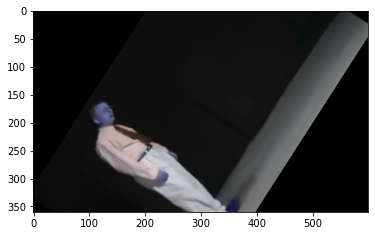

In [54]:
plt.imshow(given_rad_rotation[0])

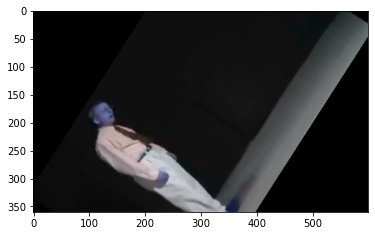

In [55]:
plt.imshow(given_rad_rotation[1])

In [72]:
#이 안에 레이어를 쌓아서 만들 수 있는데 특정 각도로의 회전은 layer에 들어가지 않아서 따로 함수로 적용해주어야한다.
#model로 만들어놓은 이유는 나중에 다른 사용을 할 수도 있을까봐
preprocessing_model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    #불가능 #tfa.image.transform_ops.rotate(result,tf.constant(np.pi/8))
])

##  Step 2 - 2

정의된 함수 사용 - 기존에 하려던 방식

In [12]:
#원래는 param 이 clip이었는데 images로 바꾸어놓았음.
def random_noise_v(images):
    from skimage.util import random_noise
    img_array=[]
    for i in range(len(images)-1):
        image_with_random_noise = random_noise(images[i])
        img_array.append(image_with_random_noise)
    return img_array

In [14]:
random_noise_vid = random_noise_v(frame)
turn_vid = turn_video("outputs/random_noise_vid.mp4", random_noise_vid)

In [19]:
def gaussian_b(images, intensity=0.75, depth=1):
    def gaussian(X, intensity=0.75, depth=1):
        indices_gaussian = np.random.choice(
            X.shape[0], math.ceil(X.shape[0] * depth), replace=False)
        X_=[]
        for k in indices_gaussian:
            sigma_=uniform(1-intensity,intensity)
            X_.append(filters.gaussian(X[k], sigma=sigma_, multichannel=True))
        return np.asarray(X_)
    img_arrai=[]
    for i in range(len(images)-1):
        image_with_random_noise = gaussian(images[i],intensity,depth)
        img_arrai.append(image_with_random_noise)
    return img_arrai

In [98]:
#degree custom rotate 함수 만듦.
def rotation(images, degree):
    img_arr = []
    for i in range(len(images)):
        rot_img = sk.transform.rotate(images[i],degree)
        img_arr.append(rot_img)
    return img_arr

In [100]:
def random_rotation1(images):
    def random_rotation(image_array, random_degree):
        # pick a random degree of rotation between 25% on the left and 25% on the right
        return sk.transform.rotate(image_array, random_degree)
    img_arroi=[]
    random_degree = random.uniform(-25, 25)
    for i in range(len(images)-1):
        image_with_random_noise = random_rotation(images[i],random_degree)
        img_arroi.append(image_with_random_noise)
    return img_arroi

In [106]:
random_rot = random_rotation1(frame)

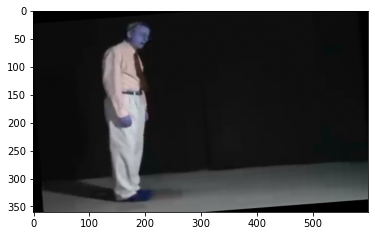

In [110]:
plt.imshow(frame[0])
plt.imshow(random_rot[10])

In [23]:
frame_arroi = []
for i in range(10):
    frame_arroi = random_rotation1(frame[i])

In [25]:
import matplotlib.pyplot as plt

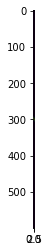

In [26]:
plt.imshow(frame_arroi[0])

In [ ]:
turn_vid = turn_video("outputs/random_noise_vid.mp4", random_noise_vid)

In [7]:
#horizontal flip de video
def flip(images):
    def horizontal_flip(image_array):
        # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
        return image_array[:, ::-1]
    img_arrei=[]
    for i in range(len(images)-1):
        image_with_random_noise = horizontal_flip(images[i])
        img_arrei.append(image_with_random_noise)
    return img_arrei

In [8]:
#invert video color
def invert(images):
    img_arrui=[]
    for i in range(len(images)-1):
        image_with_random_noise = np.invert(images[i])
        img_arrui.append(image_with_random_noise)
    return img_arrui

In [9]:
#add value to all pixels
def add(images, value):
    data_final = []
    for i in range(len(images)-1):
        image = images[i].astype(np.int32)
        image += value
        image = np.where(image > 255, 255, image)
        image = np.where(image < 0, 0, image)
        image = image.astype(np.uint8)
        data_final.append(image.astype(np.uint8))
    return data_final

In [10]:
#apply random black points on the video
def pepper(images):
    dota_final = []
    for i in range(len(images)-1):
        img = images[i].astype(np.float)
        img_shape = img.shape
        noise = np.random.randint(30, size=img_shape)
        img = np.where(noise == 0, 0, img)
        dota_final.append(img.astype(np.uint8))
    return dota_final

In [11]:
#apply random white points on the video
def salt(images):
    deta_final = []
    for i in range(len(images)-1):
        img = images[i].astype(np.float)
        img_shape = img.shape
        noise = np.random.randint(30, size=img_shape)
        img = np.where(noise == 0, 255, img)
        deta_final.append(img.astype(np.uint8))
    return deta_final

In [12]:
#if 0<ratio<1, speed up video, else 1<ratio<infinity, slows up the video
def changesample(clip, ratio):
        nb_return_frame = np.floor(ratio * len(clip))
        return_ind = [int(i) for i in np.linspace(1, len(clip), num=nb_return_frame)]
        return [clip[i-1] for i in return_ind]

## Step 3

outputs 폴더에 저장

In [56]:
#비디오 저장
def turn_video(name,clip,clip2=[],j=0,k=0): #clip2 확인하기
    h,w,l= clip[0].shape
    size=(w,h)    
    #코덱 확인 다시하기
    #param : 파일 저장될 이름, 코덱 (mp4 파일은 mp4v 사용), 초 당 프레임 수, 저장 사이즈
    out = cv2.VideoWriter(name,cv2.VideoWriter_fourcc(*'mp4v'), 15, size)# 동영상 재생 시간 2배 예상
    i=0
    for i in range(len(clip)-j):#if the python returns something with NoneType put j=1
        if k == 1: #k=1 to random noise, gaussian blur and random rotate
            out.write(np.uint8(clip[i]*clip2[i]))
        else:
            #print(clip[i].dtype) -> none type error 체크
            out.write(np.uint8(clip[i]))
    out.release()

In [57]:
#비디오 생성(저장)
turn_vid = turn_video("turn_video.mp4", given_rad_rotation)

## 다른 참조 

In [ ]:
while (cap.isOpened()):
    ret, frame = cap.read()

    if ret:
        # 이미지 반전,  0:상하, 1 : 좌우
        frame = cv2.flip(frame, 0)

        out.write(frame)

        cv2.imshow('frame', frame)

        if cv2.waitKey(0) & 0xFF == ord('q'):
            break
    else:
        break
        
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

In [28]:
import cv2
import pafy

In [29]:
file = 'abnormal_gait1.mp4'
url = 'https://www.youtube.com/watch?v=y160w4sAQNw&list=PLD74972DCFB2D58C8'

In [30]:
#video = pafy.new(url)
cap = cv2.VideoCapture(file)

# frame 사이즈
frame_size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
              int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
print('frame_size =', frame_size)

frame_size = (800, 480)


In [31]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

In [32]:
out1 = cv2.VideoWriter('./output/record0.mp4',fourcc, 20.0, frame_size)
out2 = cv2.VideoWriter('./output/record1.mp4',fourcc, 20.0, frame_size,isColor=False)

In [ ]:
cnt =0

while True:
    retval, frame = cap.read()	# 영상을 한 frame씩 읽어오기
    if not retval:
        break   
    
    cnt+=1    
    out1.write(frame)	# 영상 파일에 저장   
    
    # 이미지 컬러 변환
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    out2.write(gray)	# 영상 파일에 저장        
    
    cv2.imshow('frame',frame)	# 이미지 보여주기
    cv2.imshow('gray',gray)      
    
    key = cv2.waitKey(25)
    if key == 27:
        break
        
cap.release()	# 객체 해제
out1.release()
out2.release()
cv2.destroyAllWindows()



In [ ]:
# extract and save the video frames
while cap.isOpened():
    ret, frame = cap.read()
    if ret:
        cv2.imwrite('test_frame_'+str(i)+'.png', frame)
        

In [ ]:
#필요없음. -> 위에 수정해놓음
#다른 방법
def custom_get_frames(video_path):
    video = cv2.VideoCapture(video_path)
    def customGetFrame():
        count = 0
        while(video.isOpened()):
            ret, image = video.read()
            
    
    video.release()